# Experiment plotting

This notebook contains the code for plotting results for the different experiments.
When run for the first time for a town, condensed summary files are being created which strongly speed up subsequent generations of plots from the same summaries. It is possible to create the plots only from the condensed summaries located in 'summaries/condensed_summaries'.
Note that this works for all experiments but the Rt plots, which still require the full summary file.


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import pickle
from lib.measures import *
from lib.experiment import Experiment, Plot, Result, get_properties, load_summary_list, load_summary
from lib.data import collect_data_from_df
from lib.calibrationSettings import calibration_lockdown_dates, calibration_start_dates, calibration_mob_paths
from lib.calibrationFunctions import get_calibrated_params, downsample_cases
from lib.plot import Plotter
from lib.plot import extract_data_from_summary, load_extracted_data
#from lib.experiment import Plot

In [3]:
places = [('GER', 'TU'), ('GER', 'RH'), ('GER', 'KL'), ('CH', 'TI'), ('CH', 'BE'), ('CH', 'JU')]

ymax_counterfactual = {'CH' : {'TI': 5000, 'BE': 40000, 'JU': 25000},
        'GER': {'TU': 4000, 'KL': 2000, 'RH': 3500}}

ymax_modelfit = {'GER': {'TU': 1200, 'KL': 800, 'RH': 1000, 'TR': 2000,},
                 'CH': {'VD': 2000, 'BE': 600, 'TI': 500, 'JU': 500,}}


places = [('GER', 'TU')]

## Model fit

In [12]:
def plot_model_fit(country, area, ymax):
    # Format: {`filename for plot` : `list of `Plot` objects`}
    plots = {
        f'model-fit-{country}-{area}' : [
            Plot(label='COVID-19 simulated case data', 
                path=(f'continued-lockdown-{country}-{area}/'
                      f'continued-lockdown-{country}-{area}-extended_lockdown_weeks=100.pk')),
        ],
    }

    for plot_filename, plots in plots.items():

        # extract plot info
        labels = get_properties(plots, 'label')
        paths = get_properties(plots, 'path')

        # load simulations
        results = load_summary_list(paths)
        sims = get_properties(results, 'metadata')
        summaries = get_properties(results, 'summary')

        # plots
        plotter = Plotter()

        start_date = calibration_start_dates[country][area]
        start_date_lockdown = calibration_lockdown_dates[country]['start']
        end_date = calibration_lockdown_dates[country]['end']

        days_until_lockdown = (pd.to_datetime(start_date_lockdown) - pd.to_datetime(start_date)).days        
        
        mob_settings_paths = calibration_mob_paths[country][area][1]
        with open(mob_settings_paths, 'rb') as fp:
            mob_settings = pickle.load(fp)

        area_cases = collect_data_from_df(country=country,
             area=area,
             datatype='new',
             start_date_string=start_date,
             end_date_string=end_date)

        sim_cases = downsample_cases(area_cases, mob_settings)      # only downscaling due LK data for cities

        plotter.plot_positives_vs_target(
            paths, 
            labels,
            sim_cases.sum(axis=1),
            title='Calibration period',
            filename=plot_filename,
            figsize=(6, 4),
            start_date=start_date,
            errorevery=1, acc=1000,
            ymax=ymax[country][area],
            lockdown_at=days_until_lockdown,
            lockdown_label_y=ymax[country][area]/4
        )

        

GER TU
Extracting data from summary: continued-lockdown-GER-TU/continued-lockdown-GER-TU-extended_lockdown_weeks=100.pk
Data extraction successful.
Loaded previously extracted data.


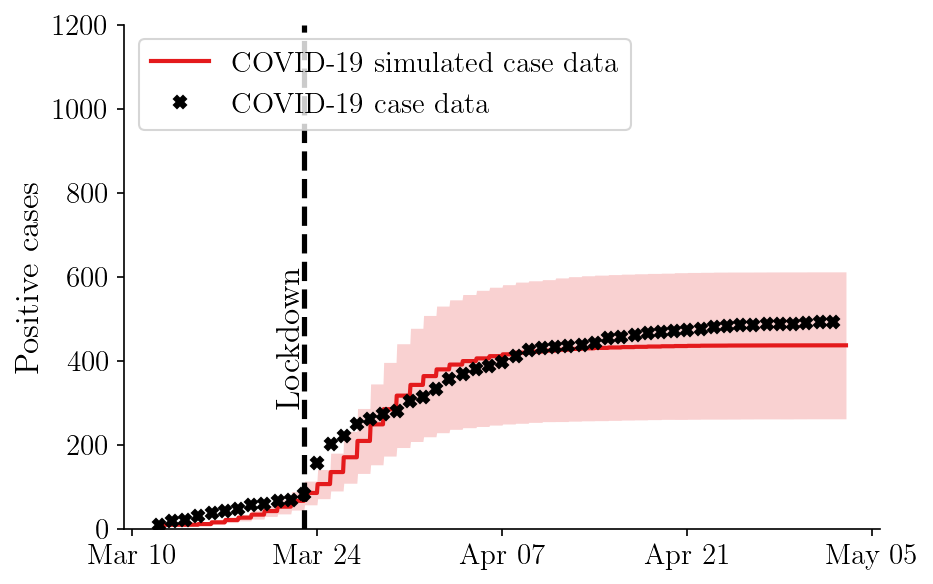

In [13]:
for country, area in places:
    print(country, area)
    plot_model_fit(country, area, ymax_modelfit)

# Counterfactual analyses

### Continued lockdown

In [14]:
def plot_continued_lockdown(country, area, ymax, plot_rt=False):
    # Format: {`filename for plot` : `list of `Plot` objects`}
    plots = {
        f'continued-lockdown-{country}-{area}' : [
            Plot(label='No interventions',
                path=(f'baseline-{country}-{area}/'
                      f'baseline-{country}-{area}-baseline.pk')),
            Plot(label='Open after 2 weeks', 
                path=(f'continued-lockdown-{country}-{area}/'
                      f'continued-lockdown-{country}-{area}-extended_lockdown_weeks=2.pk')),
            Plot(label='Open after 4 weeks',
                path=(f'continued-lockdown-{country}-{area}/'
                      f'continued-lockdown-{country}-{area}-extended_lockdown_weeks=4.pk')),
            Plot(label='Lockdown', 
                path=(f'continued-lockdown-{country}-{area}/'
                      f'continued-lockdown-{country}-{area}-extended_lockdown_weeks=100.pk')),
        ],
    }


    for plot_filename, plots in plots.items():

        # extract plot info
        labels = get_properties(plots, 'label')
        paths = get_properties(plots, 'path')

        # plots
        plotter = Plotter()

        start_date = calibration_start_dates[country][area]
        start_date_lockdown = calibration_lockdown_dates[country]['start']
        end_date = calibration_lockdown_dates[country]['end']

        days_until_lockdown = (pd.to_datetime(start_date_lockdown) - pd.to_datetime(start_date)).days

        plotter.compare_total_infections(
            paths, 
            titles=labels, 
            filename=plot_filename, 
            start_date=start_date,
            figsize=(6,4), 
            legend_is_left=True,
            lockdown_label_y=ymax[country][area]/5,
            legendXoffset=0.015,
            lockdown_at=days_until_lockdown,
            lockdown_label='Interventions',
            ymax=ymax[country][area], 
            errorevery=14)
        
        if plot_rt:
            indices = [3]    # Show Rt for the best working strategy only
            
            paths = [paths[i] for i in indices]
            results = load_summary_list(paths)
            sims = get_properties(results, 'metadata')
            summaries = get_properties(results, 'summary')
        
            for summary, sim in zip(summaries, sims):
                plot_name = sim.experiment_info
                plotter.plot_daily_rts(summary, 
                                       filename=plot_name+'-Rt', 
                                       start_date=start_date, 
                                       titles=None,
                                       figsize=(6,4), 
                                       lockdown_label='Interventions',
                                       lockdown_at=days_until_lockdown, 
                                       lockdown_label_y=3, 
                                       ymax=None, 
                                       errorevery=1, 
                                       )

In [ ]:
for country, area in places:
    print(country, area)
    plot_continued_lockdown(country, area, ymax_counterfactual, plot_rt=True)

GER TU
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Extracting data from summary: continued-lockdown-GER-TU/continued-lockdown-GER-TU-extended_lockdown_weeks=100.pk


### K groups

In [ ]:
def plot_k_groups(country, area, ymax, plot_rt=False):
    # Format: {`filename for plot` : `list of `Plot` objects`}
    plots = {
        f'k-groups-{country}-{area}' : [
            Plot(label='Lockdown', 
                path=(f'continued-lockdown-{country}-{area}/'
                      f'continued-lockdown-{country}-{area}-extended_lockdown_weeks=100.pk')),
            Plot(label='K = 2',
                path=(f'k-groups-{country}-{area}/'
                      f'k-groups-{country}-{area}-K_groups=2.pk')),
            Plot(label='K = 3',
                path=(f'k-groups-{country}-{area}/'
                      f'k-groups-{country}-{area}-K_groups=3.pk')),
            Plot(label='K = 4', 
                path=(f'k-groups-{country}-{area}/'
                      f'k-groups-{country}-{area}-K_groups=4.pk')),
        ],

    }

    for plot_filename, plots in plots.items():

        # extract plot info
        labels = get_properties(plots, 'label')
        paths = get_properties(plots, 'path')

        # plots
        plotter = Plotter()

        start_date = calibration_start_dates[country][area]
        start_date_lockdown = calibration_lockdown_dates[country]['start']
        days_until_lockdown = (pd.to_datetime(start_date_lockdown) - pd.to_datetime(start_date)).days

        plotter.compare_total_infections(
            paths,
            titles=labels, 
            filename=plot_filename, 
            start_date=start_date,
            figsize=(6,4), 
            legend_is_left=True,
            lockdown_label_y=ymax[country][area]/5,
            legendXoffset=0.015,
            lockdown_at=days_until_lockdown,
            lockdown_label='Interventions',
            ymax=ymax[country][area], 
            errorevery=14)
        
        
        if plot_rt:
            indices = [3]    # Show Rt for the best working strategy only
            
            paths = [paths[i] for i in indices]
            results = load_summary_list(paths)
            sims = get_properties(results, 'metadata')
            summaries = get_properties(results, 'summary')
        
            for summary, sim in zip(summaries, sims):
                plot_name = sim.experiment_info
                plotter.plot_daily_rts(summary, 
                                       filename=plot_name+'-Rt', 
                                       start_date=start_date, 
                                       titles=None, 
                                       lockdown_label='Intervention',
                                       lockdown_at=days_until_lockdown, 
                                       lockdown_label_y=3, 
                                       ymax=None, 
                                       errorevery=1, 
                                       )



In [ ]:
ymax = {'GER': {'TU': 1200}}

for country, area in places:
    print(country, area)
    plot_k_groups(country, area, ymax, plot_rt=False)

### Vulnerable Groups


In [ ]:
def plot_vulnerable_groups(country, area, ymax, ymax_hosp):
    # Format: {`filename for plot` : `list of `Plot` objects`}
    plots = {
        f'vulnerable-groups-{country}-{area}' : [
            Plot(label='No interventions',
                path=(f'baseline-{country}-{area}/'
                      f'baseline-{country}-{area}-baseline.pk')),
            Plot(label='Lockdown', 
                path=(f'continued-lockdown-{country}-{area}/'
                      f'continued-lockdown-{country}-{area}-extended_lockdown_weeks=100.pk')),
            Plot(label='Vulnerable groups', 
                path=(f'vulnerable-groups-{country}-{area}/'
                      f'vulnerable-groups-{country}-{area}-.pk')),
        ],

    }

    for plot_filename, plots in plots.items():

        # extract plot info
        labels = get_properties(plots, 'label')
        paths = get_properties(plots, 'path')

        # plots
        plotter = Plotter()

        start_date = calibration_start_dates[country][area]
        start_date_lockdown = calibration_lockdown_dates[country]['start']
        days_until_lockdown = (pd.to_datetime(start_date_lockdown) - pd.to_datetime(start_date)).days

        plotter.compare_total_infections(
            paths,
            titles=labels, 
            filename=plot_filename,
            start_date=start_date,
            figsize=(6,4), 
            legend_is_left=True,
            lockdown_label_y=ymax[country][area]/5,
            legendXoffset=0.02,
            legendYoffset=0.02,
            lockdown_at=days_until_lockdown,
            lockdown_label='Interventions',
            ymax=ymax[country][area], 
            errorevery=14)
        
        
        plotter.compare_total_fatalities_and_hospitalizations(
            paths,
            titles=labels, 
            mode='show_hosp_only',
            filename=plot_filename+ '-hosp', 
            start_date=start_date,
            figsize=(6,4), 
            legendXoffset=0.02,
            legendYoffset=0.02,
            legend_is_left=True,
            lockdown_at=days_until_lockdown,
            lockdown_label_y=ymax_hosp[country][area]/5,
            lockdown_label='Interventions',
            ymax=ymax_hosp[country][area], 
            errorevery=14)
        
        
        plotter.compare_total_fatalities_and_hospitalizations(
            paths,
            titles=labels, 
            mode='show_dead_only',
            filename=plot_filename+ '-dead', 
            start_date=start_date,
            figsize=(6,4), 
            legendXoffset=0.02,
            legendYoffset=0.02,
            legend_is_left=True,
            lockdown_at=days_until_lockdown,
            lockdown_label_y=ymax_hosp[country][area]/5,
            lockdown_label='Interventions',
            ymax=ymax_hosp[country][area]/2, 
            errorevery=14)

In [ ]:
ymax_hosp = {
    'CH' : {'TI' : 150, 'BE': 1000, 'JU': 600},
    'GER': {'TU': 150, 'KL': 20, 'RH': 40}
}

for country, area in places:
    print(country, area)
    plot_vulnerable_groups(country, area, ymax_counterfactual, ymax_hosp)

# Contact tracing

### Contact tracing test delay and testing

In [ ]:
def plot_contact_tracing_isolation(country, area, ymax, single_runs=False, plot_rt=False):
    # Format: {`filename for plot` : `list of `Plot` objects`}
    plots = {
        f'tracing-{country}-{area}' : [
            Plot(label='Isolate \& test, 48h delay, test all',
                path=(f'tracing-{country}-{area}/'
                      f'tracing-{country}-{area}-tracing=isolate+test-delay=48.0-contacts_tested=100000-test_policy=basic.pk')),
            Plot(label='Isolate only, 48h delay',
                path=(f'tracing-{country}-{area}/'
                      f'tracing-{country}-{area}-tracing=isolate-delay=48.0-contacts_tested=None-test_policy=None.pk')),
            Plot(label='Isolate only, 3h delay',
                path=(f'tracing-{country}-{area}/'
                      f'tracing-{country}-{area}-tracing=isolate-delay=3.0-contacts_tested=None-test_policy=None.pk')),
        ]
    }

    for plot_filename, plots in plots.items():

        # extract plot info
        labels = get_properties(plots, 'label')
        paths = get_properties(plots, 'path')

        # plots
        plotter = Plotter()

        plotter.compare_total_infections(
            paths, 
            titles=labels, 
            filename=plot_filename, 
            show_single_runs=False,
            figsize=(6,4), 
            legend_is_left=True,
            legendXoffset=0.015,
            ymax=ymax[country][area],
            x_axis_dates=False,
            x_label_interval=3,
            errorevery=14)

        
        if single_runs:
            plotter.compare_total_infections(
                paths, 
                titles=labels, 
                filename=plot_filename + '-single', 
                show_single_runs=3,
                figsize=(6,4), 
                legend_is_left=True,
                legendXoffset=0.015,
                ymax=ymax[country][area],
                x_axis_dates=False,
                x_label_interval=3,
                errorevery=14)
            
        if plot_rt:
            indices = [0]    # Show Rt for the best working strategy only
            
            paths = [paths[i] for i in indices]
            results = load_summary_list(paths)
            sims = get_properties(results, 'metadata')
            summaries = get_properties(results, 'summary')
        
            for summary, sim in zip(summaries, sims):
                plot_name = sim.experiment_info
                plotter.plot_daily_rts(summary, 
                                       filename=plot_name+'-Rt', 
                                       titles=None, 
                                       ymax=None,
                                       x_axis_dates=False,
                                       figsize=(6,4),
                                       errorevery=1, 
                                       )
            
        

In [ ]:
ymax = {
    'CH' : {'TI' : 100, 'JU': 200, 'BE': 300},
    'GER' : {'TU' : 350, 'KL': 150, 'RH': 200},
}

for country, area in places:
    print(country, area)
    plot_contact_tracing_isolation(country, area, ymax, plot_rt=True)

### Adoption levels of contact tracing with isolation and testing

In [ ]:
def plot_tracing_isolation_compliance(country, area, ymax, single_runs=False):
    # Format: {`filename for plot` : `list of `Plot` objects`}
    plots = {
        f'tracing-compliance-{country}-{area}' : [
            Plot(label='No interventions', 
                path=(f'baseline-scenario-b-{country}-{area}/'
                      f'baseline-scenario-b-{country}-{area}-baseline.pk')),
            Plot(label='25\% compliance',
                path=(f'tracing-compliance-{country}-{area}/'
                      f'tracing-compliance-{country}-{area}-p=0.25.pk')),
            Plot(label='50\% compliance',
                path=(f'tracing-compliance-{country}-{area}/'
                      f'tracing-compliance-{country}-{area}-p=0.5.pk')),
            Plot(label='65\% compliance',
                path=(f'tracing-compliance-{country}-{area}/'
                      f'tracing-compliance-{country}-{area}-p=0.65.pk')),
            Plot(label='75\% compiance',
                path=(f'tracing-compliance-{country}-{area}/'
                      f'tracing-compliance-{country}-{area}-p=0.75.pk')),
            Plot(label='100\% compliance',
                path=(f'tracing-{country}-{area}/'
                      f'tracing-{country}-{area}-tracing=isolate+test-delay=48.0-contacts_tested=100000-test_policy=basic.pk')),
        ]
    }

    for plot_filename, plots in plots.items():

        # extract plot info
        labels = get_properties(plots, 'label')
        paths = get_properties(plots, 'path')

        # plots
        plotter = Plotter()

        plotter.compare_total_infections(
            paths, 
            titles=labels, 
            filename=plot_filename, 
            show_single_runs=False,
            figsize=(6,4),
            legend_is_left=True,
            lockdown_label_y=1000,
            legendXoffset=0.015,
            ymax=ymax[country][area],
            x_axis_dates=False,
            x_label_interval=3,
            errorevery=14)
        
        if single_runs:
            plotter.compare_total_infections(
                paths, 
                titles=labels, 
                filename=plot_filename + '-single', 
                show_single_runs=5,
                figsize=(6,4),  
                legend_is_left=True,
                lockdown_label_y=1000,
                legendXoffset=0.015,
                ymax=ymax[country][area] * 1.5,
                x_label_interval=3,
                errorevery=14)

        

In [ ]:
ymax = {'CH' : {'TI': 5000, 'BE': 40000, 'JU': 25000},
        'GER': {'TU': 20000, 'KL': 2000, 'RH': 3500}}

for country, area in places:
    print(country, area)
    plot_tracing_isolation_compliance(country, area, ymax)

### Increased efficiency using the advanced testing policy

In [ ]:
def plot_advanced_testing_policy(country, area, ymax, plot_daily_tested=False):
    # Format: {`filename for plot` : `list of `Plot` objects`}
    plots = {
        f'tracing-test-efficiency-{country}-{area}' : [
            Plot(label='Isolate \& test all',
                path=(f'tracing-{country}-{area}/'
                      f'tracing-{country}-{area}-tracing=isolate+test-delay=48.0-contacts_tested=100000-test_policy=basic.pk')),
            Plot(label='Isolate \& test top 20 risk',
                path=(f'tracing-{country}-{area}/'
                      f'tracing-{country}-{area}-tracing=isolate+test-delay=48.0-contacts_tested=20-test_policy=advanced.pk')),
        ]
    }

    for plot_filename, plots in plots.items():
        # extract plot info
        labels = get_properties(plots, 'label')
        paths = get_properties(plots, 'path')

        # plots
        plotter = Plotter()

        plotter.compare_total_infections(
             paths, 
             titles=labels, 
             filename=plot_filename, 
             show_single_runs=False,
             figsize=(6,4), 
             legend_is_left=True,
             ymax=ymax[country][area] / 2,
             legendXoffset=0.015,
             x_axis_dates=False,
             errorevery=14)
        
        if plot_daily_tested:
            # load simulations
            results = load_summary_list(paths)
            sims = get_properties(results, 'metadata')
            summaries = get_properties(results, 'summary')
            
            for summary, label in zip(summaries, labels):
                plotter.plot_daily_tested(
                    summary, 
                    title=label, 
                    filename=plot_filename + '-' + label, 
                    acc=500)
            
            

In [ ]:
ymax = {
    'CH' : {'TI' : 100, 'JU': 200, 'BE': 300},
    'GER' : {'TU' : 350, 'KL': 150, 'RH': 200},
}

for country, area in places:
    print(country, area)
    plot_advanced_testing_policy(country, area, ymax)

## Conditional Measures

In [ ]:
def plot_conditional_measures(country, area, ymax, show_lockdowns=False):
    # Format: {`filename for plot` : `list of `Plot` objects`}
    plots = {
        f'conditional-measures-scenario-b-{country}-{area}' : [
            Plot(label='No interventions', 
                 path=(f'baseline-scenario-b-{country}-{area}/'
                       f'baseline-scenario-b-{country}-{area}-baseline.pk')),
            Plot(label='Conditional measures',
                path=(f'conditional-measures-scenario-b-{country}-{area}/'
                      f'conditional-measures-scenario-b-{country}-{area}-max_pos_tests_per_week_per_100k=50-initially_active=False.pk')),
        ]
    }
    
    for plot_filename, plots in plots.items():

        # extract plot info
        labels = get_properties(plots, 'label')
        paths = get_properties(plots, 'path')

        # plots
        plotter = Plotter()

        plotter.compare_total_infections(
            paths, 
            titles=labels, 
            filename=plot_filename, 
            show_single_runs=False,
            figsize=(6,4),
            legend_is_left=True,
            legendXoffset=0.015,
            conditional_measures=1,
            ymax=ymax[country][area],
            x_axis_dates=False,
            errorevery=14)
        
        plotter.compare_total_infections(
            paths, 
            titles=labels, 
            filename=plot_filename + '-single', 
            show_single_runs=1,
            which_single_runs=2,
            figsize=(6,4),
            legend_is_left=True,
            conditional_measures=1,
            legendXoffset=0.015,
            ymax=ymax[country][area],
            x_axis_dates=False,
            errorevery=14)
        


In [ ]:
ymax = {
    'CH' : {'TI' : 150, 'JU': 600, 'BE': 2000},
    'GER' : {'TU' : 400, 'KL': 400, 'RH': 600},
}

# BE is broken somehow, some simulations yielded enormously many cases

for country, area in places:
    print(country, area)
    plot_conditional_measures(country, area, ymax, show_lockdowns=True)

## Other experiment

In [ ]:
plots = {
    # tbd
}

## Narrowcasting Plot

In [ ]:
from lib.town_maps import MapIllustrator
from lib.settings.town_settings_tubingen import bbox

In [ ]:
day_start = 7
day_duration = 14

In [ ]:
# make sure to load a summary file that had `store_mob = True`
summary = load_summary(f'summary_file_with_mob.pk')

# plot
ill = MapIllustrator()
ill.marker_radius = 10.0
map_name = f'narrowcasting-plot-{day_start}-{day_duration}'

sitemap = ill.empirical_infection_probability_map(
    bbox=bbox, 
    site_loc=mob.site_loc, 
    site_type=mob.site_type, 
    site_dict=mob.site_dict, 
    map_name=map_name, 
    sim=summary, 
    t0=TO_HOURS * day_start, 
    t1=TO_HOURS * (day_start + day_duration), 
    delta=0.0, 
    r=0)

In [ ]:
sitemap

# Old plot ideas

### Contact Tracing with respect to test delay

In [ ]:
def plot_contact_tracing_test_delay(country, area, ymax, single_runs=False):
    # Format: {`filename for plot` : `list of `Plot` objects`}
    plots = {
        f'tracing-{country}-{area}' : [
             Plot(label='baseline', 
                 path=(f'baseline-scenario-b-{country}-{area}/'
                       f'baseline-scenario-b-{country}-{area}-baseline.pk')),
             Plot(label='isolate only, 48h delay',
                path=(f'tracing-{country}-{area}/'
                      f'tracing-{country}-{area}-tracing=isolate-delay=48.0-contacts_tested=None-test_policy=None.pk')),
             Plot(label='isolate only, 3h delay',
                path=(f'tracing-{country}-{area}/'
                      f'tracing-{country}-{area}-tracing=isolate-delay=3.0-contacts_tested=None-test_policy=None.pk')),
        ]
    }

    for plot_filename, plots in plots.items():

        # extract plot info
        labels = get_properties(plots, 'label')
        paths = get_properties(plots, 'path')

        # load simulations
        results = load_summary_list(paths)
        sims = get_properties(results, 'metadata')
        summaries = get_properties(results, 'summary')

        # plots
        plotter = Plotter()

        start_date = sims[0].start_date 
        start_date_lockdown = calibration_lockdown_dates[sims[0].country]['start']
        days_until_lockdown = (pd.to_datetime(start_date_lockdown) - pd.to_datetime(start_date)).days

        if single_runs:
            plotter.compare_total_infections(
                summaries, 
                titles=labels, 
                filename=plot_filename + '-single', 
                show_single_runs=3,
                start_date=start_date,
                figsize=(6,4), acc=500, 
                legend_is_left=True,
                legendXoffset=0.015,
                ymax=ymax[sims[0].country][sims[0].area],
                x_label_interval=3,
                errorevery=14)

        plotter.compare_total_infections(
            summaries, 
            titles=labels, 
            filename=plot_filename, 
            show_single_runs=False,
            start_date=start_date,
            figsize=(6,4), acc=500, 
            legend_is_left=True,
            legendXoffset=0.015,
            ymax=ymax[sims[0].country][sims[0].area],
            x_label_interval=3,
            errorevery=14)

### Combining testing with isolation for contact tracing

In [ ]:
def plot_contact_tracing_isolation(country, area, ymax, single_runs=False):
    # Format: {`filename for plot` : `list of `Plot` objects`}
    plots = {
        f'tracing-{country}-{area}' : [
            Plot(label='isolate+test, 48h delay, test all',
                path=(f'tracing-{country}-{area}/'
                      f'tracing-{country}-{area}-tracing=isolate+test-delay=48.0-contacts_tested=100000-test_policy=basic.pk')),
            Plot(label='isolate only, 48h delay',
                path=(f'tracing-{country}-{area}/'
                      f'tracing-{country}-{area}-tracing=isolate-delay=48.0-contacts_tested=None-test_policy=None.pk')),
        ]
    }

    for plot_filename, plots in plots.items():

        # extract plot info
        labels = get_properties(plots, 'label')
        paths = get_properties(plots, 'path')

        # load simulations
        results = load_summary_list(paths)
        sims = get_properties(results, 'metadata')
        summaries = get_properties(results, 'summary')

        # plots
        plotter = Plotter()

        start_date = sims[0].start_date 
        start_date_lockdown = calibration_lockdown_dates[sims[0].country]['start']
        days_until_lockdown = (pd.to_datetime(start_date_lockdown) - pd.to_datetime(start_date)).days

        
        if single_runs:
            plotter.compare_total_infections(
                summaries, 
                titles=labels, 
                filename=plot_filename + '-single', 
                show_single_runs=3,
                start_date=start_date,
                figsize=(6,4), acc=500, 
                legend_is_left=True,
                legendXoffset=0.015,
                ymax=ymax[sims[0].country][sims[0].area],
                x_label_interval=3,
                errorevery=14)

        plotter.compare_total_infections(
            summaries, 
            titles=labels, 
            filename=plot_filename, 
            show_single_runs=False,
            start_date=start_date,
            figsize=(6,4), acc=500, 
            legend_is_left=True,
            legendXoffset=0.015,
            ymax=ymax[sims[0].country][sims[0].area],
            x_label_interval=3,
            errorevery=14)
        
        